# trello sum up

### import

In [37]:
import json
import re
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
from collections import defaultdict

### request trello api

In [38]:
c

In [39]:
url = "https://api.trello.com/1/boards/5f759e09df24970c22bc8f91"

headers = {
   "Accept": "application/json"
}

query = {
   'key': '544b96c8f335d94840a26be0eb860820',
   'token': token,
   'cards': 'all',
   'lists': 'all',
   'labels': 'all',
}

response = requests.request(
   "GET",
   url,
   headers=headers,
   params=query
)

data = json.loads(response.text)

### helpers

In [40]:

cards = data['cards']
lists = data['lists']
labels = data['labels']

others = {
    'id': 'others',
    'name': 'others',
    'color': 'white',
}

LAB_N = { l['name']: l for l in labels}
LAB_ID = { l['id']: l for l in labels}
LABELS = [l['name'] for l in labels]
r = regex_point = re.compile(r'.*\((\d+)\).*')

def translate(label):
    if label == 'others':
        return 'others'
    try:
        res = LAB_ID[label]['name']
    except:
        res = LAB_N[label]['id']
    return res

def paint(color):
    if color == 'sky': return 'deepskyblue'
    if color == 'black': return 'grey'
    return color
    
cards = cards_with_points = [
    c for c in data['cards'] if re.match(r, c['name'])
]


In [41]:
class Deck:
    def __init__(self, data, weeks):
        self._data = data
        self.lists = self.set_lists(data, weeks)
        self.labels = self.set_labels(data, weeks)
        self.cards = self.set_cards(data, weeks)
        
    def set_cards(self, data, weeks):
        cards = [Card(labels_dct=self._labels, **c) for c in data["cards"]]
        cards = [c for c in cards if c.idList in self.lists and c.point]
        self._cards = {c.id:c for c in cards}
        return cards

    def set_labels(self, data, weeks):
        labels = [Label(**d) for d in data["labels"]]
        self.clients = [c for c in set(l.client for l in labels) if c]
        self._labels = {l.id:l for l in labels}
        return labels

    def get_label(self, label_id):
        return self._labels[label_id]

    def get_client_points(self):
        w = defaultdict(lambda: defaultdict(int))
        for card in self.cards:
            labels = [l for l in card.labels if l.client]
            if not len(labels):
                w['other']['other'] += card.point
            for l in labels:
                w[l.client][l.mission] += card.point / len(labels)
        return w

    def get_client_mission_weights(self):
        pass

    def set_lists(self, data, weeks):
        weeks = [f'week {w}' for w in weeks]
        lists_name = [lst for lst in data["lists"]]
        lists = [lst for lst in data["lists"] if lst["name"] in weeks]
        if not len(lists) == len(weeks):
            raise Exception('cannot find lists')
        return {lst["id"]: lst for lst in lists}


class Label:
    def __init__(self, id, name, color, **kwargs):
        self.id = id
        self.name = name
        self.color = color
        
        if color == "black":
            self.client, self.mission = name.split(' / ')
        else:
            self.client, self.mission = None, None
    
    def init(self, labels):
        self.labels = [Label(**l) for l in labels]

    def __repr__(self):
        return f"{self.name} - {self.id} - {self.color}"        
    

class Card:
    def __init__(self, id, name, idList, labels, labels_dct, **kwargs):
        self.id = id
        self.idList = idList
        try:
            self.point = int(re.match(re.compile(r'.*\((\d+)\).*'), name).groups()[0])
            self.name = name[name.find(')')+1:]
        except:
            self.point = 0
            self.name = name
        self.labels = [labels_dct[l['id']] for l in labels]
    
    def __repr__(self):
        return f"{self.name} - {len(self.labels)} labels"
        
    def get_client(self):
        clients = [l.client for l in self.labels]
        if len(clients) > 2:
            raise Exception('too much client')
        return client[0] if len(client) else None


### compute weight

In [42]:
def make_autopct(values, nb_days):
    def my_autopct(pct):
        total = sum(values)
        val = nb_days*pct/100
        return '{p:.2f}%  ({v:.1f}j)'.format(p=pct,v=val)
    return my_autopct

def flatten(lst):
    return [elem for sublst in lst for elem in sublst]
    
def plot(deck, period, nb_days=20):
    fig, ax = plt.subplots(figsize=(10,10))

    size = 0.3
    vals = []
    labels = []
    data = deck.get_client_points()
    for k, v in data.items():
        if k == 'other':
            vals.append([float(sum(v.values()))])
            labels.append(['other'])
        else:
            vals. append([vv for vv in v.values()])
            labels.append([f'{k} - {kk}' for kk in v.keys()])
    vals = np.array(flatten(vals))
    labels = flatten(labels)

    #vals = np.array([[60., 32.], [37., 40.], [29., 10.], [29.,10.]])

    cmap = plt.get_cmap("tab20c")
    outer_colors = cmap(np.arange(len(data))*4)

    inner_colors = [[4*i+j+1 for j in range(len(missions))] for i, missions in enumerate(data.values())]
    inner_colors = flatten(inner_colors)
    inner_colors = cmap(np.array(inner_colors))
    #inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10, 13, 14]))

    ax.pie(vals, radius=1, colors=inner_colors, labels=labels, autopct=make_autopct(vals, nb_days))

    ax.set(aspect="equal", title=period)
    plt.show()

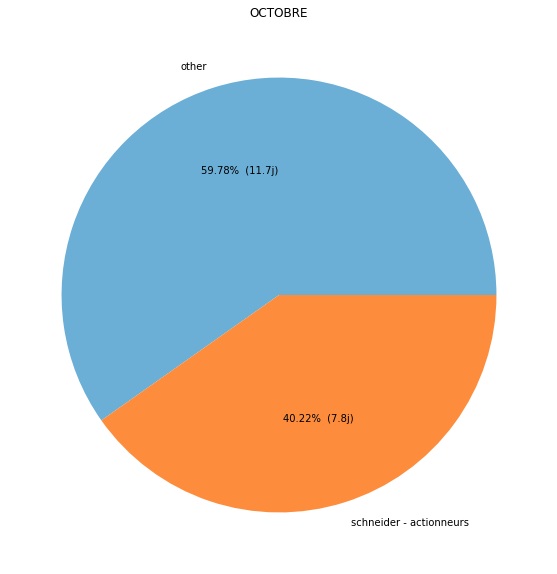

In [43]:
plot(Deck(data, [41,42,43,44]), "OCTOBRE", 19.5)

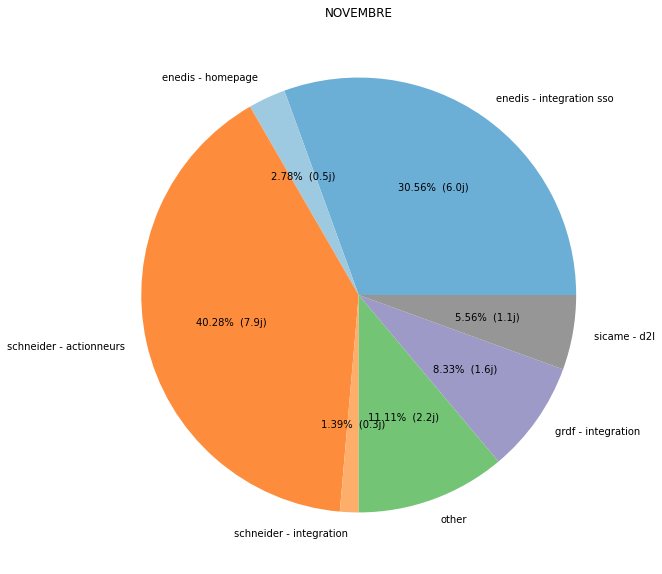

In [44]:
plot(Deck(data, [45,46,47,48]), "NOVEMBRE", 19.5)

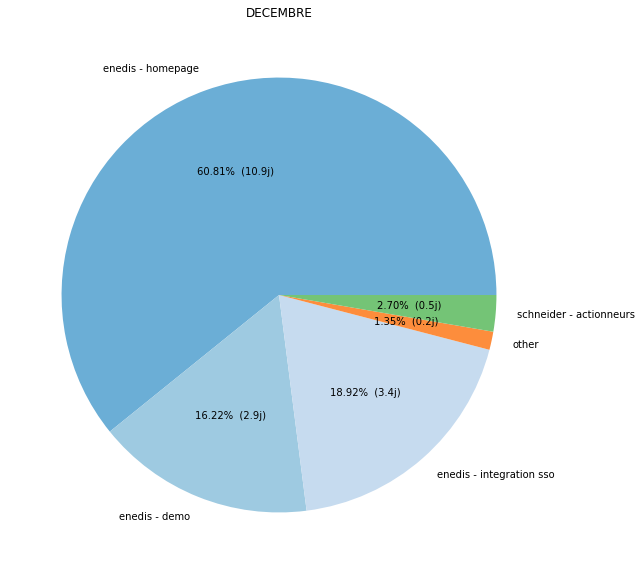

In [45]:
plot(Deck(data, [49,50,51,52]), "DECEMBRE", 18)

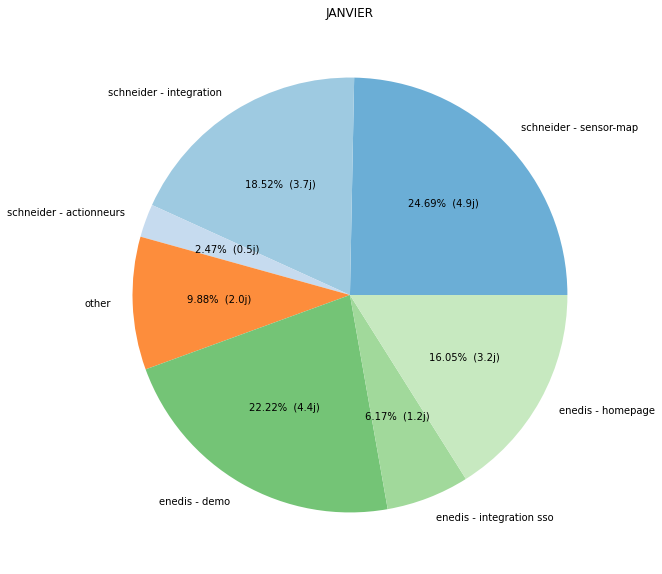

In [46]:
plot(Deck(data, [1,2,3,4]), "JANVIER")

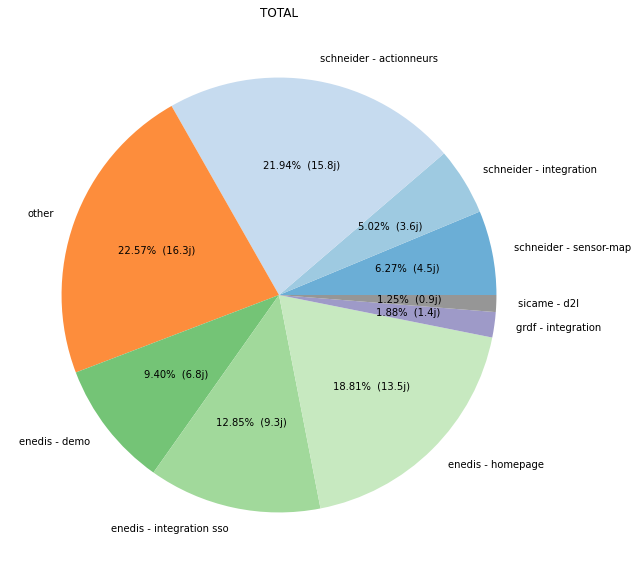

In [47]:
plot(Deck(data, [41,42,43,44,45,46,47,48, 49,50,51, 52, 1, 2, 3, 4]), "TOTAL", 72)